## Voice Recognition Classification

**Imports & Functions**

In [1]:
# Imports
import numpy as np
import pandas as pd
from io import StringIO

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support, accuracy_score, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve, cross_val_score

kfold = KFold(n_splits=5)

In [2]:
# Random Forest feature importance Function
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'Importance':m.feature_importances_}
                       ).sort_values('Importance', ascending=False)

In [3]:
# Random Forest feature importance Plot Function
def plot_fi(fi):
    return fi.plot('cols', 'Importance', 'barh', figsize=(12,7), legend=False)

## Exploratory Data Analysis

### Reading the Dataset

In [4]:
voicef=r'voice.csv'
voiceDf = pd.read_csv(voicef)
voiceDf.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


### Dataset Discription:
<li>The goal is to classify the gender based on the voice features</li>
<li>The dataset containts 21 columns including 20 attributes and 1 taregt values whcih is the gender</li>
<li>The Dimensions of the dataset are 3167x21</li>

## Data Wrangling & visualization

### Dataset Attributes:

<ol>
<li>meanfreq: mean frequency (in kHz)</li>
<li>sd: standard deviation of frequency</li>
<li>median: median frequency (in kHz)</li>
<li>Q25: first quantile (in kHz)</li>
<li>Q75: third quantile (in kHz)</li>
<li>IQR: interquantile range (in kHz)</li>
<li>skew: skewness</li>
<li>kurt: kurtosis</li>
<li>sp.ent: spectral entropy</li>
<li>sfm: spectral flatness</li>
<li>centroid: frequency centroid (see specprop)</li>
<li>peakf: peak frequency (frequency with highest energy)</li>
<li>meanfun: average of fundamental frequency measured across acoustic signal</li>
<li>minfun: minimum fundamental frequency measured across acoustic signal</li>
<li>maxfun: maximum fundamental frequency measured across acoustic signal</li>
<li>meandom: average of dominant frequency measured across acoustic signal</li>
<li>mindom: minimum of dominant frequency measured across acoustic signal</li>
<li>maxdom: maximum of dominant frequency measured across acoustic signal</li>
<li>dfrange: range of dominant frequency measured across acoustic signal</li>
<li>modindx: modulation index. Calculated as the accumulated absolute difference between adjacent measurements of fundamental frequencies divided by the frequency range </li>
<li>label: male or female</li></ol>

In [5]:
voiceDf.dtypes.unique()

array([dtype('float64'), dtype('O')], dtype=object)

**As shown above all the features are numerical and the target value is an object.**

In [6]:
voiceDf.isnull().sum()

meanfreq    0
sd          0
median      0
Q25         0
Q75         0
IQR         0
skew        0
kurt        0
sp.ent      0
sfm         0
mode        0
centroid    0
meanfun     0
minfun      0
maxfun      0
meandom     0
mindom      0
maxdom      0
dfrange     0
modindx     0
label       0
dtype: int64

**There's no missing data in any of the features in the dataset**

now we need to convert the laberl column into numerical to be able to visualize the dataset

In [9]:
voiceDf["label"] = LabelEncoder().fit_transform(voiceDf["label"]) # 1 -> male , 0-> female

### Data Visualization

C:\Users\hp\anaconda3\lib\site-packages\seaborn\axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


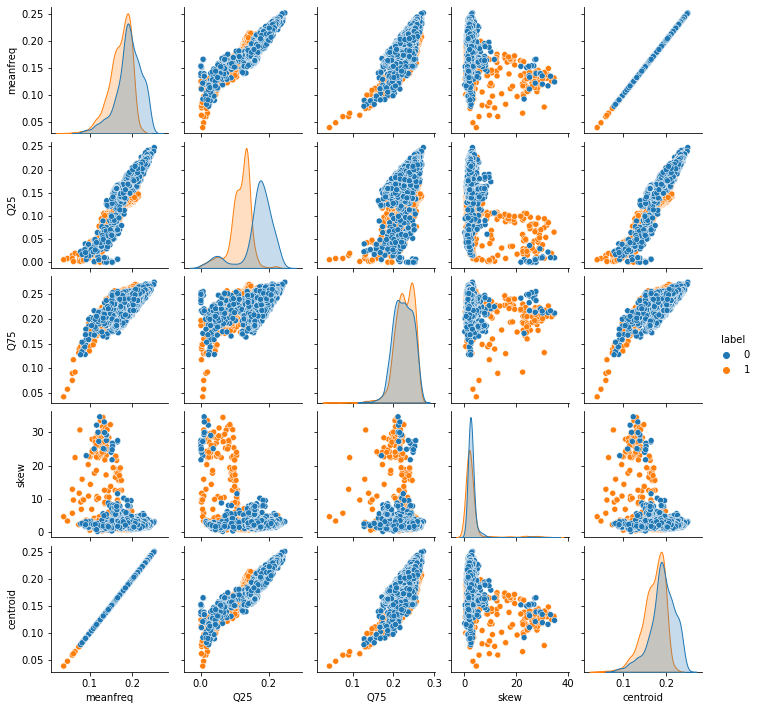

In [11]:
sns.pairplot(voiceDf[['meanfreq', 'Q25', 'Q75', 'skew', 'centroid', 'label']], hue='label', size=2)

**This pairplot is plotted to show the relations between the dataset features and we find that the skewness with the quartiles are having a weak relation unlike the meanfreq with the centroid as they have a strong relation.**

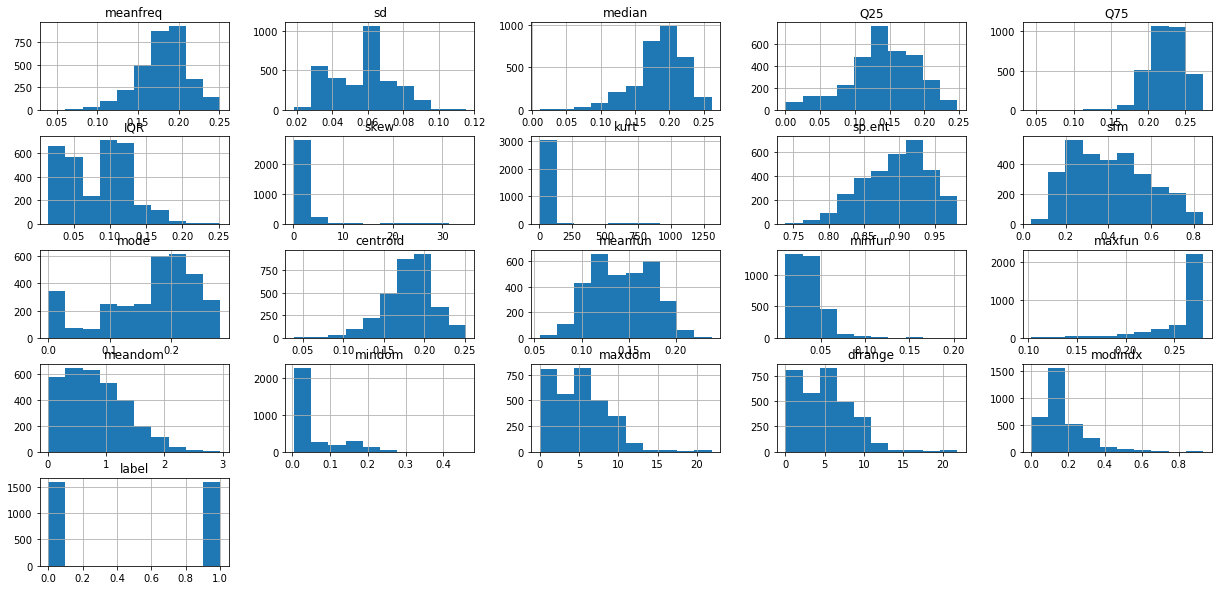

In [12]:
voiceDf.hist(figsize=(21, 10))
plt.show()

**The bar charts above to show if there is any outliers; and by looking at it we can se that the data does not contain alot of outliers and the highest features that contains outliers is the skewness  and kurt; also we can find that The Data is not biased as it is split evenly between the class (50% males, 50% females).**

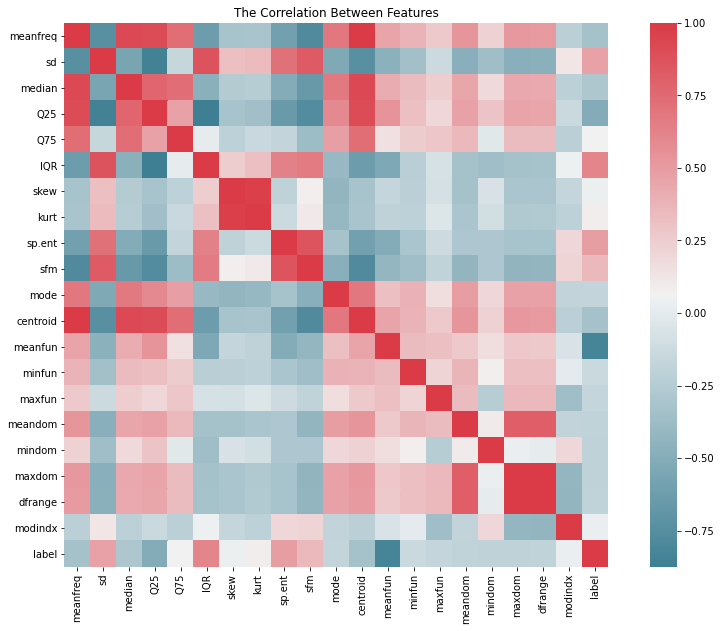

In [15]:
f, ax = plt.subplots(figsize=(15, 10))
corr = voiceDf.corr()
sns.heatmap(corr,mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.title('The Correlation Between Features')
plt.show()

**This Heatmap shows the correlations between the features; and by looking at it we find a positive correlation between the label and IQR, label and sp.ent, and a huge negative correlation between the label and meanfun.**

## Data Preprocessing

**We first split the dataset into the feature, class**

In [11]:
gender_label = voiceDf.iloc[:, -1].to_numpy()
voiceDf1 = voiceDf.iloc[:, :-1]

**Then splitting them into train, validation sub-datasets**

In [13]:
voiceX_train, voiceX_test, voiceY_train, voiceY_test = train_test_split(voiceDf1, gender_label, test_size=0.3, random_state=42)

**Scaling the dataset**
- Fiting the scaler on the training features
- Transforming the validation features


In [14]:
sc1= StandardScaler()
voiceX_train = sc1.fit_transform(voiceX_train)
voiceX_test = sc1.transform(voiceX_test)

## Machine Learning Models

### K-Nearest Neighbor

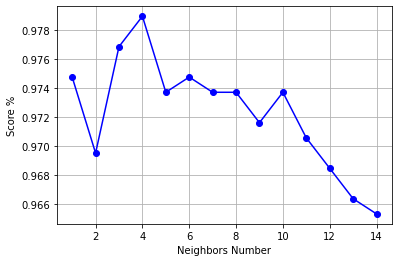

In [15]:
# KNN test run to determine the optimal n_neighbors
knn_valid_score_list=[]
n_neighbors_num = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]

for i in range(1,15):
    test_knn = KNeighborsClassifier(n_neighbors=i)
    test_knn.fit(voiceX_train, voiceY_train)
    knn_valid_score_list.append(test_knn.score(voiceX_test, voiceY_test))
    
plt.plot(n_neighbors_num,  knn_valid_score_list, "b")
plt.plot(n_neighbors_num,  knn_valid_score_list, "bo")
plt.xlabel("Neighbors Number")
plt.ylabel("Score %")
plt.grid(True)
plt.show()

**After this test train for the KNN we found that the best n_neighbor = 4 as shown in the figure above, so we train with the optimal parameter** 

In [16]:
# Best Model Build
knn = KNeighborsClassifier(n_neighbors=4).fit(voiceX_train, voiceY_train)

# Model Prediction
voice_pred_knn=knn.predict(voiceX_test)
prf_knn=precision_recall_fscore_support(voiceY_test, voice_pred_knn, average='macro')

# Model Evaluation Methods
voice_score_knn = accuracy_score(voice_pred_knn, voiceY_test)
accuracy_results_knn = cross_val_score(knn, voiceX_train, voiceY_train, cv=kfold).mean()
Precision_knn = prf_knn[0]
Recall_knn = prf_knn[1]
f1_knn = prf_knn[2]

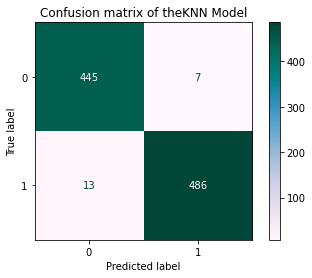

In [17]:
plot_confusion_matrix(knn,voiceX_test, voiceY_test, cmap='PuBuGn')
plt.title('Confusion matrix of theKNN Model')
plt.show()

**After we calculated the different evaluation we plot the confution matrix**

### Support Vector Machine

In [18]:
# Model Build
svm = SVC().fit(voiceX_train,voiceY_train)

# Model Prediction
voice_pred_svm=svm.predict(voiceX_test)
prf_svm=precision_recall_fscore_support(voiceY_test, voice_pred_svm, average='macro')

# Model Evaluation Methods
voice_score_svm = accuracy_score(voice_pred_svm, voiceY_test)
accuracy_results_svm = cross_val_score(svm, voiceX_train, voiceY_train, cv=kfold).mean()
Precision_svm = prf_svm[0]
Recall_svm = prf_svm[1]
f1_svm = prf_svm[2]

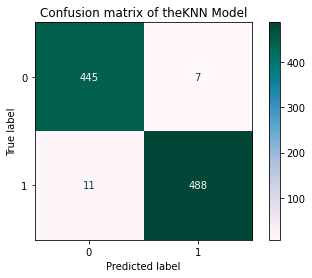

In [19]:
plot_confusion_matrix(svm,voiceX_test, voiceY_test, cmap='PuBuGn')
plt.title('Confusion matrix of theKNN Model')
plt.show()

**After we calculated the different evaluation we plot the confution matrix**

### Random Forest

In [20]:
# Model Build
rf = RandomForestClassifier(n_estimators=100).fit(voiceX_train, voiceY_train)

# Model Prediction
voice_pred_rf = rf.predict(voiceX_test)
prf_rf=precision_recall_fscore_support(voiceY_test, voice_pred_rf, average='macro')

# Model Evaluation Methods
voice_score_rf = accuracy_score(voice_pred_rf, voiceY_test)
accuracy_results_rf = cross_val_score(rf, voiceX_train, voiceY_train, cv=kfold).mean()
Precision_rf = prf_rf[0]
Recall_rf = prf_rf[1]
f1_rf = prf_rf[2]

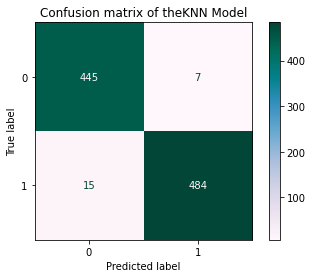

In [21]:
plot_confusion_matrix(rf,voiceX_test, voiceY_test, cmap='PuBuGn')
plt.title('Confusion matrix of theKNN Model')
plt.show()

**After we calculated the different evaluation we plot the confution matrix**

**Also we can extract the importance of each feature according to the random forest classifier and plot it in a line chart**

In [22]:
rf_importance = rf_feat_importance(rf, voiceDf1)
rf_importance.head()

,cols,Importance
12,meanfun,0.345317
5,IQR,0.193297
3,Q25,0.138430
8,sp.ent,0.070835
1,sd,0.069536


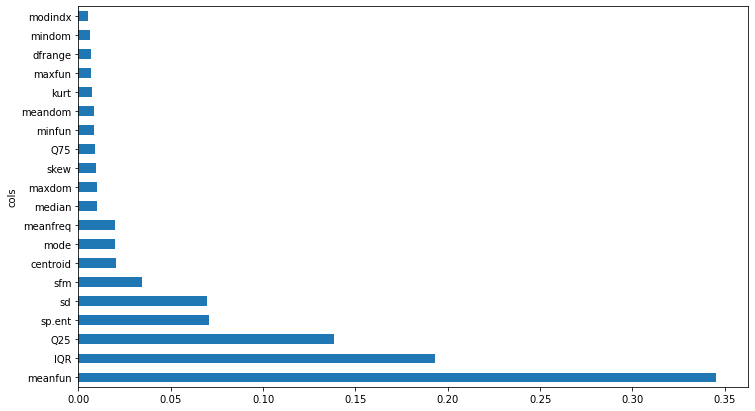

In [23]:
plot_fi(rf_importance);

**we find that the meanfun is the most important feature among all the features then comes IQR**

## Learning Curves
here we plot the learning curves for all the models to give extra insight on the performance of the model

In [24]:
knn_train_sizes, knn_train_scores, knn_valid_scores, *_ = learning_curve(knn, voiceX_train, voiceY_train, n_jobs=-1,
                                                        random_state=42, cv=3)

svm_train_sizes, svm_train_scores, svm_valid_scores, *_ = learning_curve(svm, voiceX_train, voiceY_train, n_jobs=-1,
                                                        random_state=42, cv=3)

rf_train_sizes, rf_train_scores, rf_valid_scores, *_ = learning_curve(rf, voiceX_train, voiceY_train, n_jobs=-1,
                                                        random_state=42, cv=3)

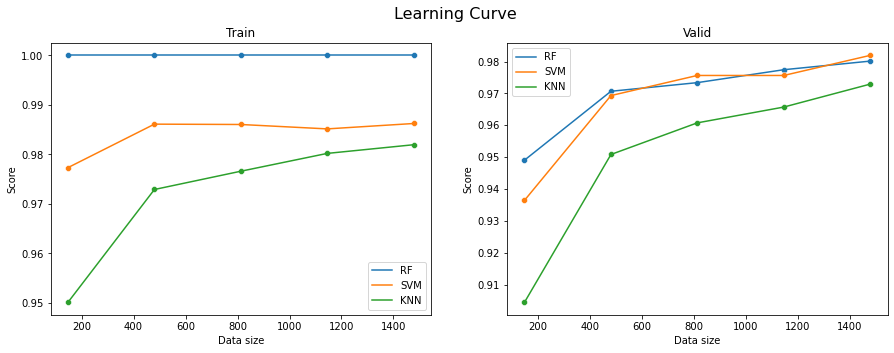

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Learning Curve', fontsize=16)
# The Training Plots
sns.scatterplot(ax=axes[0], x= rf_train_sizes, y= rf_train_scores.mean(axis=1))
sns.lineplot(ax=axes[0], x= rf_train_sizes, y= rf_train_scores.mean(axis=1))
sns.scatterplot(ax=axes[0], x= svm_train_sizes, y= svm_train_scores.mean(axis=1))
sns.lineplot(ax=axes[0], x= svm_train_sizes, y= svm_train_scores.mean(axis=1))
sns.scatterplot(ax=axes[0], x= knn_train_sizes, y= knn_train_scores.mean(axis=1))
sns.lineplot(ax=axes[0], x= knn_train_sizes, y= knn_train_scores.mean(axis=1))
axes[0].set_title('Train')
axes[0].set_xlabel('Data size')
axes[0].set_ylabel('Score')
axes[0].legend(['RF', 'SVM', 'KNN'])

# The Validation Plots
sns.scatterplot(ax=axes[1], x= rf_train_sizes, y= rf_valid_scores.mean(axis=1))
sns.lineplot(ax=axes[1], x= rf_train_sizes, y= rf_valid_scores.mean(axis=1))
sns.scatterplot(ax=axes[1], x= svm_train_sizes, y= svm_valid_scores.mean(axis=1))
sns.lineplot(ax=axes[1], x= svm_train_sizes, y= svm_valid_scores.mean(axis=1))
sns.scatterplot(ax=axes[1], x= knn_train_sizes, y= knn_valid_scores.mean(axis=1))
sns.lineplot(ax=axes[1], x= knn_train_sizes, y= knn_valid_scores.mean(axis=1))
axes[1].set_title('Valid')
axes[1].set_xlabel('Data size')
axes[1].set_ylabel('Score')
axes[1].legend(['RF', 'SVM', 'KNN'])
plt.show()

### Models' Performance Evaluation Table
the below table compares the applied models using different evaluation metrics which are: `model.score`,`Cross Validation`,  `Precision`, `Recall`, `F1 Score` in order to see which model is the **optimal** model for this dataset

In [26]:
model_performance_table = pd.DataFrame({
    'Model': ['SVM', 'KNN', 'RF'],
    'Model Score': [voice_score_svm, voice_score_knn, voice_score_rf],
    'Cross Validation': [accuracy_results_svm, accuracy_results_knn, accuracy_results_rf],
    'Valid Precision': [Precision_svm, Precision_knn, Precision_rf],
    'Valid Recall': [Recall_svm, Recall_knn, Recall_rf],
    'Valid F1 Score': [f1_svm, f1_knn, f1_rf]
})

model_performance_table.sort_values(by="Model Score", ascending=False)

,Model,Model Score,Cross Validation,Valid Precision,Valid Recall,Valid F1 Score
0,SVM,0.981073,0.980602,0.980868,0.981235,0.981034
1,KNN,0.978970,0.973388,0.978708,0.979231,0.978930
2,RF,0.976866,0.981055,0.976567,0.977227,0.976827


Looking at the table above we find that the **Support Vectore Machine** Model achieved the best performance with accuracy of **98.1%** and the **Random Forest** Model comes the second with accuracy of **98%** which is only **0.1%** lower than the SVM.